In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np

In [ ]:
# Create a random graph
nodes = [1, 2, 3, 4, 5, 6]
input_nodes = [1, 2]  # Should have no incoming edges
output_nodes = [6]  # Should have no outgoing edges
hidden_nodes = [3, 4, 5]

edges = [
    (1, 6),
    (1, 3),
    (1, 4),
    (2, 6),
    (2, 3),
    (2, 4),
    (2, 5),
    (3, 6),
    (3, 5),
    (4, 5),
    (5, 6)
]

g = nx.DiGraph()
for e in edges:
    g.add_edge(e[0], e[1], weight=np.random.rand() - 0.5)
    
# Random input
random_input = [np.random.rand(), np.random.rand()]

In [ ]:
# Draw our graph
n_colors = []
for n in g.nodes():
    if n in input_nodes:
        n_colors.append('purple')
    elif n in output_nodes:
        n_colors.append('yellow')
    else:
        n_colors.append('blue')
        
e_colors = []
e_widths = []
for e in g.edges():
    w = g.get_edge_data(e[0], e[1])['weight']
    e_widths.append(abs(w) * 5)
    e_colors.append(['red', 'green'][w > 0])

plt.figure(figsize=(15, 15))
pos = nx.spring_layout(g)
nx.draw_networkx_nodes(g, pos, node_color=n_colors)
nx.draw_networkx_labels(g, pos)
nx.draw_networkx_edges(g, pos, width=e_widths, edge_color=e_colors)
plt.show()

In [ ]:
import itertools

# https://github.com/CodeReclaimers/neat-python/blob/99da17d4bd71ec97d7f37c9b5df0006c7689a893/neat/graphs.py
def required_for_output(inputs, outputs, connections):
    # Keep track of all nodes going to the outputs
    req = set(outputs)
    t = req
    
    while t:  # While we can find new nodes
        # Find new nodes not in req with an edge to a node in req
        # TODO: create dict with neighbor nodes to reduce time
        t = set(a for (a, b) in connections if b in req and a not in req)
        
        # Remove the input nodes
        t -= set(inputs)
        
        # Update nodes that go to the outputs
        req = [req, req.union(t)][t is not None]

    return req


def feed_forward_layers(inputs, outputs, connections):
    # Get the nodes that eventually lead to an output node
    required = required_for_output(inputs, outputs, connections)
    t = set(inputs)
    
    layers = [set(inputs)]
    while t:
        # Get all nodes from layers (flatten the list)
        s = set(itertools.chain(*layers))
        
        # Find candidate nodes c for the next layer.  These nodes should connect
        # a node in s to a node not in s.
        # TODO: create dict with neighbor nodes
        c = set(b for (a, b) in connections if a in s and b not in s)
        
        # Discard unrequired nodes
        c = c.intersection(set(required))
        
        # Keep only the used nodes whose entire input set is contained in s.
        t = set()
        for n in c:
            # TODO: create dict
            if all(a in s for (a, b) in connections if b == n):
                t.add(n)

        if len(t):
            layers.append(t)

    # Remove the inputs
    layers.remove(set(inputs))
    return layers

In [ ]:
layers = feed_forward_layers(input_nodes, output_nodes, edges)
layers

In [27]:
from itertools import chain
from collections import defaultdict

import matplotlib.pyplot as plt
import networkx as nx
import numpy as np

class Neuron:
    activation_functions = {
        'linear': lambda x: x,
        'tanh': lambda x: np.tanh(x)
    }
    def __init__(self, name, activation_function='linear'):
        if activation_function not in Neuron.activation_functions:
            raise ValueError("The provided activation function is not valid.")
            
        self.name = name
        self.activation_function = Neuron.activation_functions[activation_function]

class Connection:
    def __init__(self, neuron_from, neuron_to, weight):
        self.neuron_from = neuron_from
        self.neuron_to = neuron_to
        self.weight = weight

class Network:
    def __init__(self, inputs, outputs, connections):
        self.inputs = inputs
        self.outputs = outputs
        self.connections = connections
        
        # Get all unique nodes in the network
        to_nodes = [x.neuron_from for x in connections]
        from_nodes = [x.neuron_to for x in connections]
        all_nodes = set(inputs + outputs + to_nodes + from_nodes)
        self.neurons = list(all_nodes)
        
        # Create adjacency dict of dicts & neighbor dict of lists
        self.adjacency = {}
        self.neighbors = {}
        self.neighbors_rev = {}
        for node in self.neurons:
            self.adjacency[node] = defaultdict(lambda: None)
            self.neighbors[node] = []
            self.neighbors_rev[node] = []
        
        for connection in connections:
            self.adjacency[connection.neuron_from][connection.neuron_to] = connection
            self.neighbors[connection.neuron_from].append(connection.neuron_to)
            self.neighbors_rev[connection.neuron_to].append(connection.neuron_from)
            
    def has_connection(self, neuron_from, neuron_to):
        return self.adjacency[neuron_from][neuron_to] is not None
    
    def get_neighbors(self, neuron_from):
        return self.neighbors[neuron_from]
    
    def get_neurons_to(self, neuron_to):
        return self.neighbors_rev[neuron_to]
    
    def visualize(self):
        g = nx.DiGraph()
        # Draw our graph
        n_colors = []
        for n in sorted(self.neurons, key=lambda x: x.name):
            g.add_node(n.name)
            if n in self.inputs:
                n_colors.append('purple')
            elif n in self.outputs:
                n_colors.append('yellow')
            else:
                n_colors.append('blue')
        
        e_colors = []
        e_widths = []
        for conn in self.connections:
            w = g.add_edge(conn.neuron_from.name, conn.neuron_to.name, weight=conn.weight)
            e_widths.append(abs(conn.weight) * 5)
            e_colors.append(['red', 'green'][conn.weight > 0])

        plt.figure(figsize=(15, 15))
        pos = nx.spring_layout(g)
        nx.draw_networkx_nodes(g, pos, node_color=n_colors)
        nx.draw_networkx_labels(g, pos)
        nx.draw_networkx_edges(g, pos, width=e_widths, edge_color=e_colors)
        plt.show()
        
    def required_for_output(self):
        # Keep track of all nodes going to the outputs
        req = set(self.outputs)
        t = req

        while t:  # While we can find new nodes
            # Find new nodes not in req with an edge to a node in req
            # TODO: replace with filter()
            t = set(y for x in req for y in self.get_neurons_to(x) if y not in req)

            # Remove the input nodes
            t -= set(self.inputs)

            # Update nodes that go to the outputs
            req = [req, req.union(t)][t is not None]

        return req


    def feed_forward_layers(self):
        # Get the nodes that eventually lead to an output node
        required = self.required_for_output()
        t = set(self.inputs)

        layers = [set(self.inputs)]
        while t:
            # Get all nodes from layers (flatten the list)
            s = set(chain(*layers))

            # Find new candidates in neighbors of already found nodes
            # TODO: replace with filter()
            c = set(y for x in s for y in self.get_neighbors(x) if y not in s)
            
            # Discard unrequired nodes
            c = c.intersection(set(required))

            # Keep only the used nodes whose entire input set is contained in s.
            # TODO: replace with filter()
            t = set(n for n in c if all(a in s for a in self.get_neurons_to(n)))
            
            # Append the new layer, if not empty
            if len(t): layers.append(t)

        # Remove the inputs
        layers.remove(set(self.inputs))
        return layers
        
    def forward_pass(self, feature_vector):
        layers = self.feed_forward_layers()
        values = {}
        for input_neuron, value in zip(self.inputs, feature_vector):
            values[input_neuron] = value
            
        for layer in layers:
            for node in layer:
                values[node] = 0
                for rev_neighbor in self.get_neurons_to(node):
                    values[node] += values[rev_neighbor] * self.adjacency[rev_neighbor][node].weight
                values[node] = node.activation_function(values[node])
                
        return [values[x] for x in self.outputs]
        


Layer 0: [3, 4]
Layer 1: [5]
Layer 2: [6]
[-0.048386311701739106]


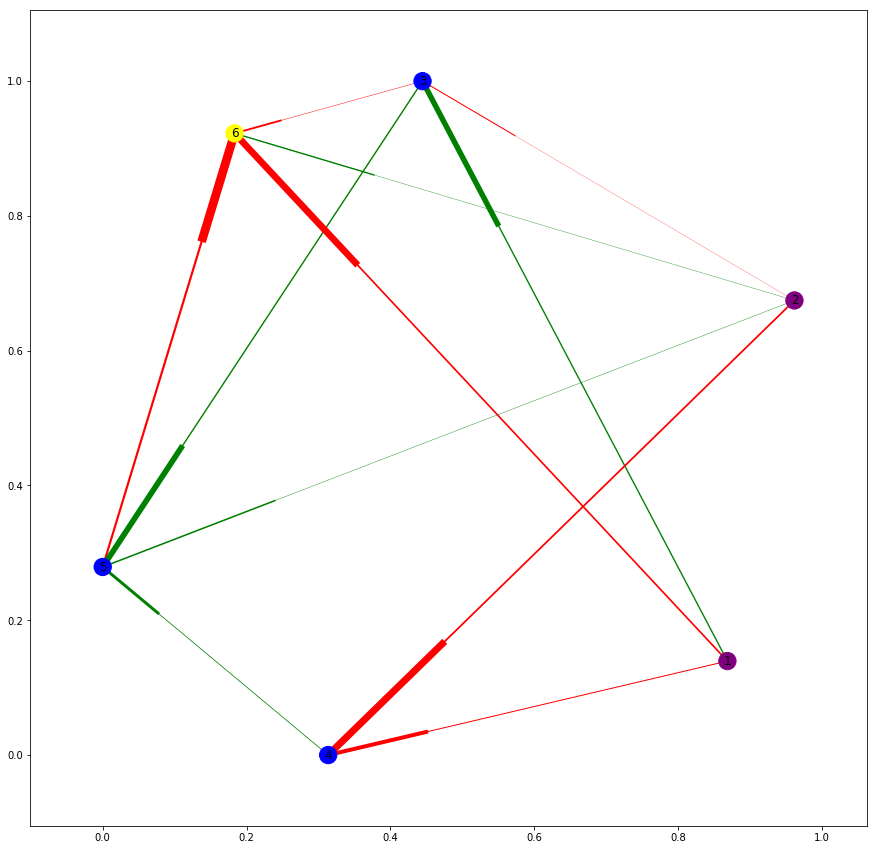

In [28]:
nodes = [1, 2, 3, 4, 5, 6]
input_nodes = [1, 2]  # Should have no incoming edges
output_nodes = [6]  # Should have no outgoing edges
hidden_nodes = [3, 4, 5]

edges = [
    (1, 6),
    (1, 3),
    (1, 4),
    (2, 6),
    (2, 3),
    (2, 4),
    (2, 5),
    (3, 6),
    (3, 5),
    (4, 5),
    (5, 6)
]

neurons = {}
connections = []

for n in nodes:
    neurons[n] = Neuron(n)
    
input_neurons = [neurons[1], neurons[2]]
output_neurons = [neurons[6]]

for e in edges:
    connections.append(Connection(neurons[e[0]], neurons[e[1]], np.random.rand() - 0.5))
    
network = Network(input_neurons, output_neurons, connections)

layers = network.feed_forward_layers()
for i, layer in enumerate(layers):
    print('Layer {}: {}'.format(i, [x.name for x in layer]))

random_input = [np.random.rand(), np.random.rand()]
print(network.forward_pass(random_input))
    
network.visualize()